In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [66]:
df = pd.read_csv('../../data/downloads/freight_model_output_20250503_125648.csv')
df.head(2)

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,multiple_commodities,priority_multiple_commodities,freight_per_invoice,standardization_status,error_summary,priority_failure_reasons,...,market_rate,xgs_applied_rate,xgs_raw_rate,freight_ratio_raw,freight_ratio_normal,rate_ratio_raw,rate_ratio_normal,market_cost_outlier,freight_ratio_raw_outlier,freight_ratio_normal_outlier
0,357863,SPN,1VNL,1485.67,True,False,191.13,SUCCESS,Standardization successful; Unsupported commod...,No priority errors found,...,0.128649,0.078207,0.078207,1.644978,1.644978,1.644969,1.644978,NORMAL,NORMAL,NORMAL
1,357870,SPCP,1VNL,6609.39,False,False,602.67,SUCCESS,Standardization successful,No priority errors found,...,0.091184,0.118680,0.118680,0.768320,0.768320,0.768322,0.768320,NORMAL,NORMAL,NORMAL


In [67]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'historical_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

In [68]:
columns_output = ['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'freight_class','shipment_type','unit', 'rate','historical_market_freight_costs','market_rate',
       'invoice_freight_commodity_cost', 'raw_invoice_cost','minimum_applied',]

In [69]:
df2 = df[columns_output]
df2.head(2)

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,freight_class,shipment_type,unit,rate,historical_market_freight_costs,market_rate,invoice_freight_commodity_cost,raw_invoice_cost,minimum_applied
0,357863,SPN,1VNL,1485.67,1M,LTL,LBS,0.078208,191.13,0.128649,116.19,116.19,False
1,357870,SPCP,1VNL,6609.39,5M,LTL,LBS,0.118679,602.67,0.091184,784.40,784.40,False


## Baseline National Model Calibration


In [70]:
# === invoice_freight_utils.py ===

import pandas as pd
import numpy as np

def simulate_freight_cost_models(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 3 freight cost simulations:
    - ltl_only_cost: Cost if only LTL used
    - xgs_threshold_cost: XGS method using vendor threshold rules
    - optimal_cost: Theoretical best (min(FTL, LTL), ignoring thresholds)

    Now supports site-specific dynamic FTL costs using distance, rate-per-mile, and minimum enforcement.
    """
    df = df.copy()

    # Step 1: Define vendor thresholds
    vendor_thresholds = {
        '1CBL': 2200,   # SQYD
        '1CPT': 2200,   # SQYD
        '1VNL': 20000   # LBS
    }

    # Define site-specific mileage and recommended truck type
    site_ftl_info = {
        'DIT': {'miles': 843, 'commodity': '1CPT', 'truck': 'Dry Van'},
        'SPW': {'miles': 1559.6, 'commodity': '1VNL', 'truck': 'Dry Van'},
        'SPN': {'miles': 329, 'commodity': '1CPT', 'truck': 'Dry Van'},
        'SPCP': {'miles': 900, 'commodity': '1CBL', 'truck': 'Dry Van'},
        'SPT': {'miles': 457, 'commodity': '1VNL', 'truck': 'Dry Van'},
        'PVF': {'miles': 1200, 'commodity': '1CBL', 'truck': 'Dry Van'},
        'SPHU': {'miles': 830, 'commodity': '1CBL', 'truck': 'Dry Van'},
        'SPTM': {'miles': 1900, 'commodity': '1VNL', 'truck': 'Dry Van'},
        'FSU': {'miles': 372, 'commodity': '1VNL', 'truck': 'Dry Van'},
        'CTS': {'miles': 1559.6, 'commodity': '1VNL', 'truck': 'Dry Van'},
        'SPJ': {'miles': 346, 'commodity': '1VNL', 'truck': 'Dry Van'},

    }

    # Truck rates and minimum charges
    rate_per_mile = {'Dry Van': 1.95, 'Flatbed': 2.548}
    min_charge = {'Dry Van': 700, 'Flatbed': 900}

    # Step 2: Ensure required columns exist
    required_cols = [
        'invoice_commodity_quantity', 'new_commodity_group', 'rate', 'unit',
        'raw_invoice_cost', 'invoice_freight_commodity_cost', 'minimum_applied', 'site'
    ]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Step 3: Compute LTL cost (respects minimum charge)
    df['ltl_only_cost'] = np.where(
        df['minimum_applied'] == True,
        df['invoice_freight_commodity_cost'],
        df['raw_invoice_cost']
    )

    # Step 4: Compute FTL cost with site logic
    def calculate_ftl_cost(row):
        info = site_ftl_info.get(row['site'], None)
        if info is None:
            return np.nan
        truck_type = info['truck']
        miles = info['miles']
        rate = rate_per_mile[truck_type]
        minimum = min_charge[truck_type]
        return max(miles * rate, minimum)

    df['ftl_cost'] = df.apply(calculate_ftl_cost, axis=1)

    # Step 5: Fallback logic for rows with rate = 0
    def fallback_ftl_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['rate'] == 0 and row['invoice_commodity_quantity'] >= threshold:
            return row['ftl_cost']
        elif row['rate'] == 0:
            return row['ltl_only_cost']
        else:
            return row['ltl_only_cost']

    df['ltl_only_cost'] = df.apply(fallback_ftl_logic, axis=1)

    # Step 6: Apply XGS vendor logic
    def xgs_cost_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['invoice_commodity_quantity'] >= threshold:
            return min(row['ftl_cost'], row['ltl_only_cost'])
        else:
            return row['ltl_only_cost']

    def xgs_method_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['invoice_commodity_quantity'] >= threshold:
            return 'FTL' if row['ftl_cost'] <= row['ltl_only_cost'] else 'LTL'
        else:
            return 'LTL'

    df['xgs_threshold_cost'] = df.apply(xgs_cost_logic, axis=1)
    df['xgs_method'] = df.apply(xgs_method_logic, axis=1)

    # Step 7: Fully optimized (ignores thresholds)
    df['optimal_cost'] = df[['ftl_cost', 'ltl_only_cost']].min(axis=1)
    df['optimal_method'] = np.where(df['ftl_cost'] <= df['ltl_only_cost'], 'FTL', 'LTL')

    # Step 8: Flag cases where threshold blocks optimal FTL use
    df['ftl_blocked'] = (df['xgs_method'] == 'LTL') & (df['optimal_method'] == 'FTL')
    df['penalty_vs_optimal'] = df['xgs_threshold_cost'] - df['optimal_cost']

    return df


## XGS Baseline Model Calibration

In [71]:
# === invoice_freight_utils.py (Patched optimal cost logic for fallback anomalies) ===

import pandas as pd
import numpy as np

def simulate_freight_cost_models_revised(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 3 freight cost simulations:
    - ltl_only_cost: Raw LTL cost if only LTL were used
    - ltl_fallback_cost: Adjusted LTL cost for modeling (accounts for fallback when rate = 0)
    - xgs_threshold_cost: XGS method using vendor threshold rules
    - optimal_cost: Theoretical best (min(FTL, LTL), ignoring thresholds)

    Uses static FTL cost per site based on vendor estimates.
    Now includes logic to catch and correctly handle fallback anomalies.
    """
    df = df.copy()

    vendor_thresholds = {
        '1CBL': 2200, '1CPT': 2200, '1VNL': 20000
    }

    site_ftl_costs = {
        'DIT': 1748.73, 'SPW': 2313.67, 'SPN': 724.83,
        'SPCP': 2160, 'SPT': 2313.67, 'PVF': 3474.81,
        'SPHU': 2160, 'SPTM': 3926.47, 'FSU': 1362.91,
        'CTS': 4405.89, 'SPJ': 2313.67
    }

    required_cols = [
        'invoice_commodity_quantity', 'new_commodity_group', 'rate', 'unit',
        'raw_invoice_cost', 'invoice_freight_commodity_cost', 'minimum_applied', 'site'
    ]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    df['ltl_only_cost'] = np.where(
        df['minimum_applied'],
        df['invoice_freight_commodity_cost'],
        df['raw_invoice_cost']
    )

    df['ftl_cost'] = df['site'].map(site_ftl_costs)

    def fallback_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['rate'] == 0:
            if row['invoice_commodity_quantity'] >= threshold:
                return row['ftl_cost']
            else:
                return row['ltl_only_cost']
        else:
            return row['ltl_only_cost']

    df['ltl_fallback_cost'] = df.apply(fallback_logic, axis=1)

    def xgs_cost(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        return min(row['ftl_cost'], row['ltl_fallback_cost']) if row['invoice_commodity_quantity'] >= threshold else row['ltl_fallback_cost']

    def xgs_method(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['invoice_commodity_quantity'] >= threshold:
            return 'FTL' if row['ftl_cost'] <= row['ltl_fallback_cost'] else 'LTL'
        else:
            return 'LTL'

    df['xgs_threshold_cost'] = df.apply(xgs_cost, axis=1)
    df['xgs_method'] = df.apply(xgs_method, axis=1)

    def robust_optimal(row):
        ftl = row['ftl_cost']
        ltl = row['ltl_fallback_cost']
        if pd.notnull(ftl) and pd.notnull(ltl):
            return min(ftl, ltl)
        elif pd.notnull(ltl):
            return ltl
        elif pd.notnull(ftl):
            return ftl
        else:
            return np.nan

    def robust_opt_method(row):
        ftl = row['ftl_cost']
        ltl = row['ltl_fallback_cost']
        if pd.notnull(ftl) and pd.notnull(ltl):
            return 'FTL' if ftl <= ltl else 'LTL'
        elif pd.notnull(ftl):
            return 'FTL'
        elif pd.notnull(ltl):
            return 'LTL'
        else:
            return 'N/A'

    df['optimal_cost'] = df.apply(robust_optimal, axis=1)
    df['optimal_method'] = df.apply(robust_opt_method, axis=1)

    df['ftl_blocked'] = (df['xgs_method'] == 'LTL') & (df['optimal_method'] == 'FTL')
    df['penalty_vs_optimal'] = df['xgs_threshold_cost'] - df['optimal_cost']

    return df


In [72]:
revised_output = simulate_freight_cost_models_revised(df2)
revised_output.head(2)

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,freight_class,shipment_type,unit,rate,historical_market_freight_costs,market_rate,...,minimum_applied,ltl_only_cost,ftl_cost,ltl_fallback_cost,xgs_threshold_cost,xgs_method,optimal_cost,optimal_method,ftl_blocked,penalty_vs_optimal
0,357863,SPN,1VNL,1485.67,1M,LTL,LBS,0.078208,191.13,0.128649,...,False,116.19,724.83,116.19,116.19,LTL,116.19,LTL,False,0.0
1,357870,SPCP,1VNL,6609.39,5M,LTL,LBS,0.118679,602.67,0.091184,...,False,784.40,2160.00,784.40,784.40,LTL,784.40,LTL,False,0.0


In [73]:
revised_output.to_csv('../../data/downloads/rates_adjusted_baseline_xgs_output_03052025.csv', index=False)

In [74]:
dat_output = simulate_freight_cost_models(df2)
dat_output.head(2)

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,freight_class,shipment_type,unit,rate,historical_market_freight_costs,market_rate,...,raw_invoice_cost,minimum_applied,ltl_only_cost,ftl_cost,xgs_threshold_cost,xgs_method,optimal_cost,optimal_method,ftl_blocked,penalty_vs_optimal
0,357863,SPN,1VNL,1485.67,1M,LTL,LBS,0.078208,191.13,0.128649,...,116.19,False,116.19,700.0,116.19,LTL,116.19,LTL,False,0.0
1,357870,SPCP,1VNL,6609.39,5M,LTL,LBS,0.118679,602.67,0.091184,...,784.40,False,784.40,1755.0,784.40,LTL,784.40,LTL,False,0.0


In [75]:
dat_output.to_csv('../../data/downloads/dat_freight_adjusted_baseline_xgs_output_03052025.csv', index=False)

In [76]:
plot_df = revised_output[(revised_output['site']=='DIT') & (revised_output['new_commodity_group'].isin(['1VNL','1CBL','1CPT']))]

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_product_vs_cost_model_grid(df, quantity_col="invoice_commodity_quantity"):
    """
    Plots a grid where:
    - Each row = one product (commodity)
    - Each column = one cost model
    - Each subplot shows:
        - Scatter for one cost model
        - Trendlines for ltl_only, optimal, and market
        - FTL average line
        - Threshold quantity line
    """

    cost_models = [
    "historical_market_freight_costs",  # moved to first
    "ltl_only_cost", "ftl_cost",
    "xgs_threshold_cost", "optimal_cost"
]

    required_cols = cost_models + ["new_commodity_group", quantity_col]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    commodities = sorted(df['new_commodity_group'].dropna().unique())
    n_rows = len(commodities)
    n_cols = len(cost_models)

    # Y-axis limit across all data
    flat_vals = df[cost_models].values.flatten()
    max_y = np.nanpercentile(flat_vals, 99)
    y_max = max_y * 1.1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 4), squeeze=False)

    for i, commodity in enumerate(commodities):
        subset = df[df["new_commodity_group"] == commodity]
        if subset.empty:
            continue

        threshold = 2200 if commodity in ["1CBL", "1CPT"] else 20000
        uom_label = "SQYD" if commodity in ["1CBL", "1CPT"] else "LBS"

        for j, cost_model in enumerate(cost_models):
            ax = axes[i][j]
            quantity = subset[quantity_col]
            cost = subset[cost_model]

            # Scatter for current cost model
            ax.scatter(quantity, cost, alpha=0.7, s=20, label=cost_model)

            if len(subset) >= 2:
                x_range = np.linspace(quantity.min(), quantity.max(), 200)

                # Trendlines
                x = quantity.values
                y_ltl = subset["ltl_only_cost"].values

               # if np.isfinite(x).all() and np.isfinite(y_ltl).all() and np.std(y_ltl) > 0:
               #     z_ltl = np.polyfit(x, y_ltl, 1)
               #     ax.plot(x_range, np.poly1d(z_ltl)(x_range), "b--", label="LTL Trend")


               # z_opt = np.polyfit(quantity, subset["optimal_cost"], 1)
               # ax.plot(x_range, np.poly1d(z_opt)(x_range), "c--", label="Optimal Trend")

               # z_market = np.polyfit(quantity, subset["calibrated_market_freight_costs"], 1)
               # ax.plot(x_range, np.poly1d(z_market)(x_range), "r--", label="Market Trend")

                ax.axhline(y=subset["ftl_cost"].mean(), color='orange', linestyle=':', label="Avg FTL")

            # Threshold line
            ax.axvline(x=threshold, color="gray", linestyle="--", linewidth=1)
            ax.text(threshold, y_max * 0.9, f"{threshold}", rotation=90,
                    color="gray", fontsize=8, ha='right', va='top')

            # Labels
            if i == 0:
                ax.set_title(cost_model.replace("_", " ").title(), fontsize=10)
            if j == 0:
                ax.set_ylabel(f"{commodity}\n\nFreight Cost ($)", fontsize=9)
            ax.set_xlabel(f"Quantity ({uom_label})", fontsize=9)

            ax.set_ylim(0, y_max)
            ax.tick_params(labelsize=8)
            ax.grid(False)

            if i == 0 and j == 0:
                ax.legend(fontsize=7, loc="upper left")

    plt.tight_layout(pad=2.0)
    plt.show()


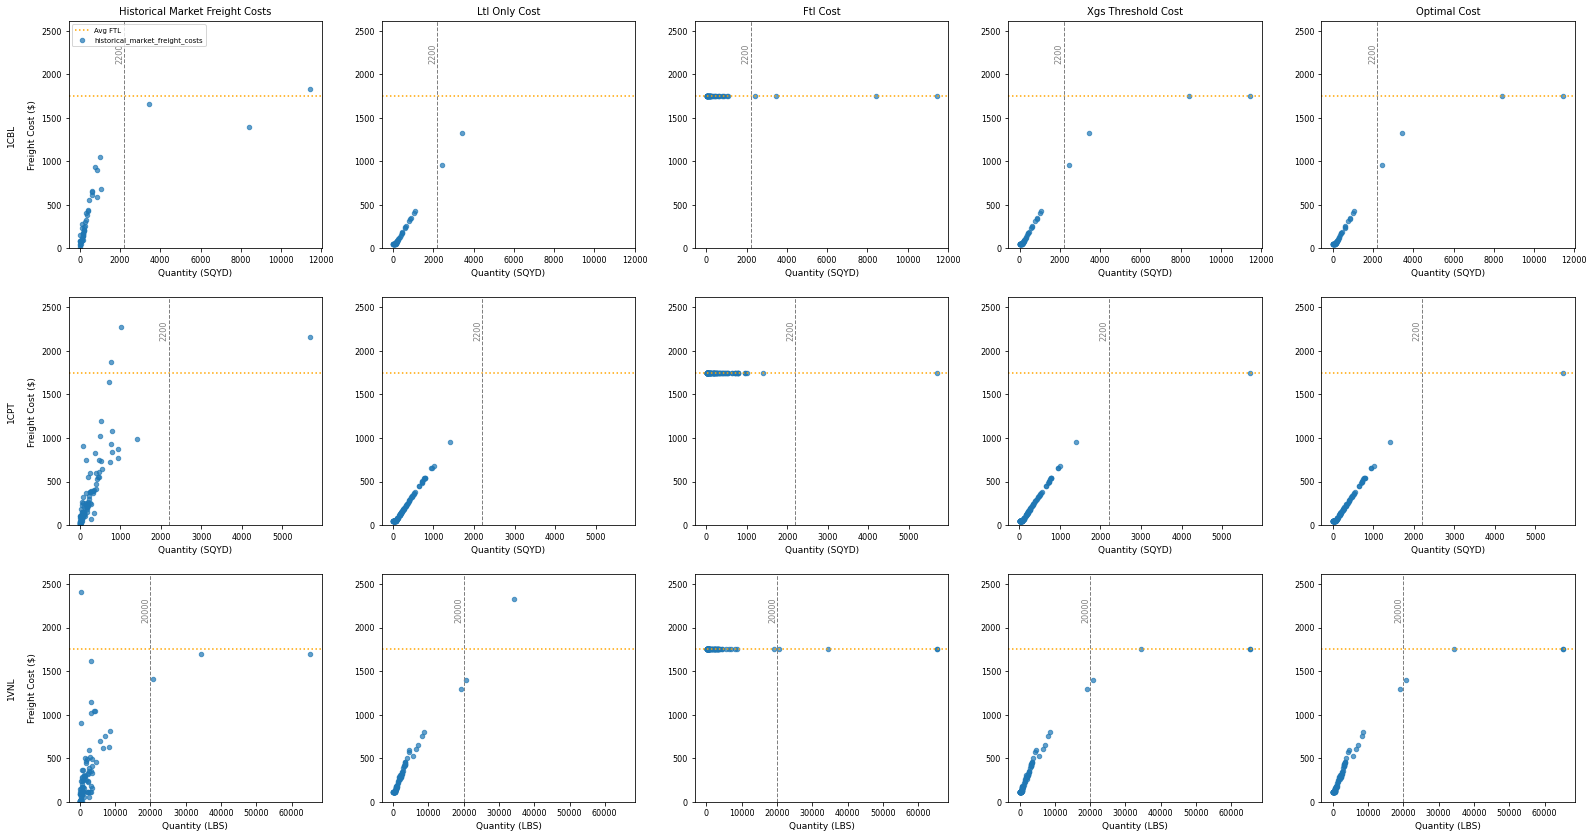

In [78]:
plot_product_vs_cost_model_grid(plot_df)


In [79]:
#plot_df.to_csv('../../data/downloads/baseline.csv')

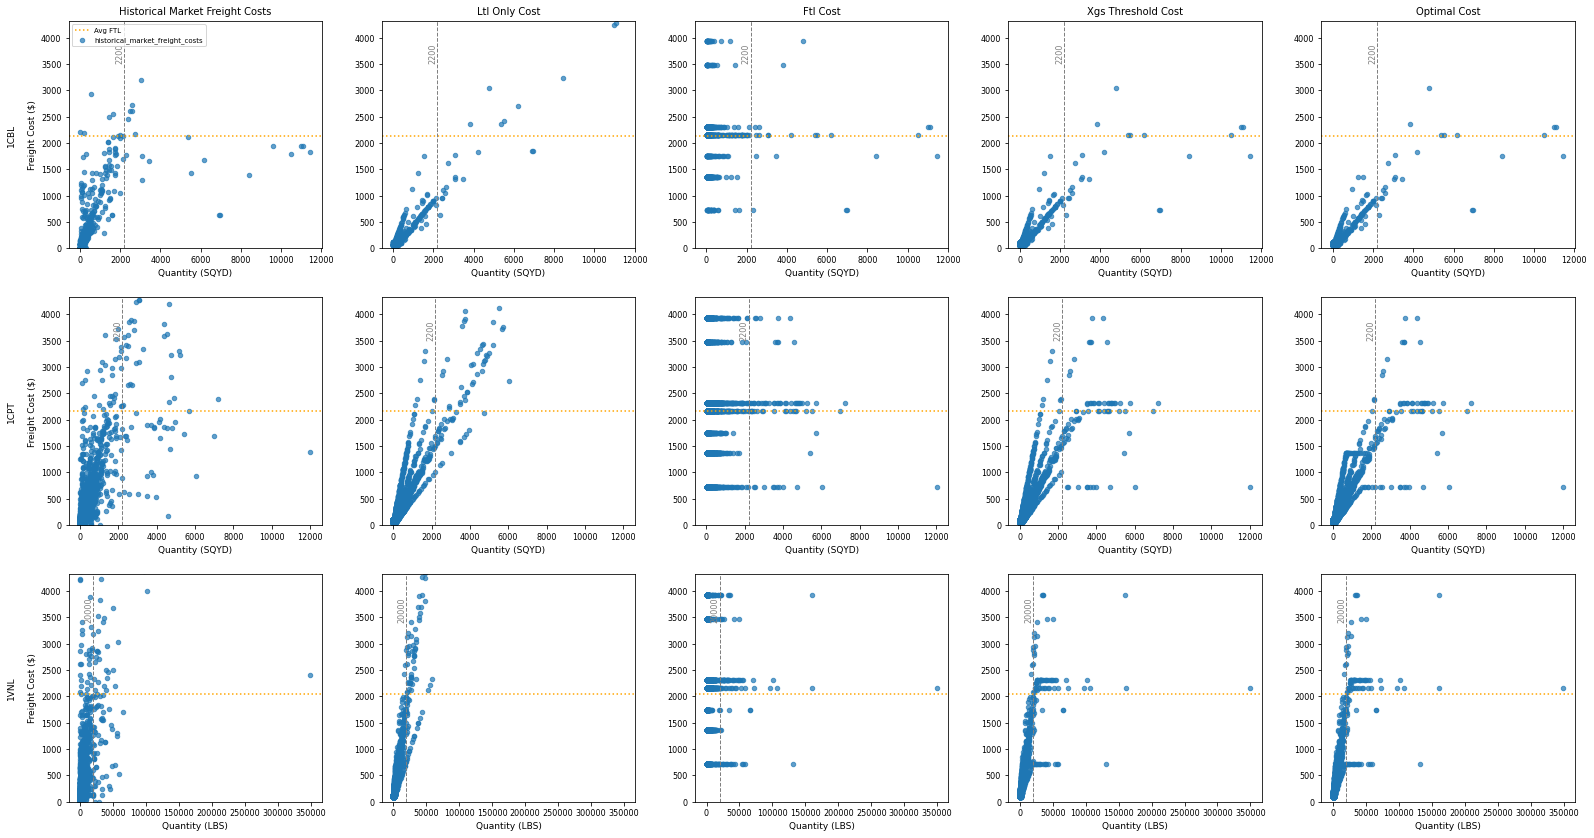

In [80]:
plot_product_vs_cost_model_grid(revised_output)